# Calendar features

Calendar features serve as key elements in time series forecasting. These features decompose date and time into basic units such as year, month, day, weekday, etc., allowing models to identify recurring patterns, understand seasonal variations, and identify trends. Calendar features can be used as [exogenous variables](../user_guides/exogenous-variables.html) because they are known for the period for which predictions are being made (the forecast horizon).

**Dates and time in Pandas**

Pandas provides a comprehensive set of capabilities tailored for handling time series data in various domains. Using the NumPy `datetime64` and `timedelta64` data types, Pandas combines a wide range of functionality from various Python libraries while introducing a wealth of novel tools to effectively manipulate time series data. This includes:

+ Easily parse date and time data from multiple sources and formats.

+ Generate sequences of fixed-frequency dates and time spans.

+ Streamline the manipulation and conversion of date-time information, including time zones.

+ Facilitate the resampling or conversion of time series data to specific frequencies.

For an in-depth exploration of Pandas' comprehensive time series and date capabilities, please refer to this [resource](https://pandas.pydata.org/docs/user_guide/timeseries.html).

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures

In [2]:
# Downloading data
# ==============================================================================
data = fetch_dataset(name="bike_sharing", raw=True)
data = data[['date_time', 'users']]
data.head()

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


,date_time,users
0,2011-01-01 00:00:00,16.0
1,2011-01-01 01:00:00,40.0
2,2011-01-01 02:00:00,32.0
3,2011-01-01 03:00:00,13.0
4,2011-01-01 04:00:00,1.0


## Extract calendar features

To take advantage of the date-time functionality offered by Pandas, the column of interest must be stored as `datetime`. Although not required, it is recommended to set it as an index for further integration with skforecast.

In [3]:
# Preprocess data
# ==============================================================================
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('h')
data = data.sort_index()
data.head()

,users
date_time,
2011-01-01 00:00:00,16.0
2011-01-01 01:00:00,40.0
2011-01-01 02:00:00,32.0
2011-01-01 03:00:00,13.0
2011-01-01 04:00:00,1.0


Next, several features are created from the date and time information: year, month, day of the week, and hour.

In [4]:
# Create calendar features
# ==============================================================================
data['year'] = data.index.year
data['month'] = data.index.month
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data.head()

,users,year,month,day_of_week,hour
date_time,,,,,
2011-01-01 00:00:00,16.0,2011,1,5,0
2011-01-01 01:00:00,40.0,2011,1,5,1
2011-01-01 02:00:00,32.0,2011,1,5,2
2011-01-01 03:00:00,13.0,2011,1,5,3
2011-01-01 04:00:00,1.0,2011,1,5,4


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

Numerous calendar-related features can be generated, including day of the year, week of the year, hour of the day, and others. An easy approach to automate their extraction is to use the <code>DatetimeFeatures</code> transformer within the **Feature-engine** Python library. This class integrates seamlessly into the scikit-learn pipeline, making it compatible with skforecast as well. For a deeper understanding and detailed information, please refer to <a href="https://feature-engine.trainindata.com/en/latest/user_guide/datetime/DatetimeFeatures.html#datetime-features">DatetimeFeatures</a>.

</div>

In [5]:
# Create calendar features with Feature-engine
# ==============================================================================
features_to_extract = ['month', 'week', 'day_of_week', 'hour']
calendar_transformer = DatetimeFeatures(
                           variables           = 'index',
                           features_to_extract = features_to_extract,
                           drop_original       = True,
                       )

calendar_features = calendar_transformer.fit_transform(data)
calendar_features.head()

,users,year,month,day_of_week,hour,week
date_time,,,,,,
2011-01-01 00:00:00,16.0,2011,1,5,0,52
2011-01-01 01:00:00,40.0,2011,1,5,1,52
2011-01-01 02:00:00,32.0,2011,1,5,2,52
2011-01-01 03:00:00,13.0,2011,1,5,3,52
2011-01-01 04:00:00,1.0,2011,1,5,4,52


## Sunlight-Related Features

Sunlight often plays a key role in time series patterns. For example, a household's hourly electricity consumption may correlate significantly with whether it's nighttime, as more electricity is typically used for lighting during those hours. Understanding and incorporating sunlight-related characteristics into analyses can provide valuable insights into consumption patterns and behavioral trends. In addition, factors such as sunrise/sunset times, seasonal changes affecting daylight, and their influence on different data sets can provide deeper context and help predict consumption fluctuations. There are several Python libraries available for extracting sunrise and sunset times. Two of the most commonly used are `pvlib` and `astral`.

In [6]:
# Features based on the sunligth
# ==============================================================================
from astral.sun import sun
from astral import LocationInfo

location = LocationInfo("Washington, D.C.", "USA")
sunrise_hour = [sun(location.observer, date=date)['sunrise'] for date in data.index]
sunset_hour = [sun(location.observer, date=date)['sunset'] for date in data.index]

# Round to the nearest hour
sunrise_hour = pd.Series(sunrise_hour, index=data.index).dt.round("h").dt.hour
sunset_hour = pd.Series(sunset_hour, index=data.index).dt.round("h").dt.hour

sun_light_features = pd.DataFrame({
                         'sunrise_hour': sunrise_hour,
                         'sunset_hour': sunset_hour}
                     )
sun_light_features['daylight_hours'] = sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
sun_light_features.tail()

,sunrise_hour,sunset_hour,daylight_hours
date_time,,,
2012-12-31 19:00:00,8,16,8
2012-12-31 20:00:00,8,16,8
2012-12-31 21:00:00,8,16,8
2012-12-31 22:00:00,8,16,8
2012-12-31 23:00:00,8,16,8


## Cyclical encoding

Certain aspects of the calendar, such as hours of the day or days of the week, behave in cycles. For example, the hours of a day range from 0 to 23. If interpreted as a continuous variable, the hour of 23:00 would be 23 units away from the hour of 00:00. However, this is not true because 23:00 is only one hour away from 00:00. The same is true for the months of the year, since December is only one month away from January. Using techniques such as trigonometric functions - sine and cosine transformations - makes it possible to represent cyclic patterns and avoid inconsistencies in data representation. This technique is called cyclic coding and can significantly improve the predictive power of models.

In [7]:
# Cyclical encoding
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = True
)

cyclical_features = cyclical_encoder.fit_transform(calendar_features)
cyclical_features.head(3)

,users,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date_time,,,,,,,,,,
2011-01-01 00:00:00,16.0,2011,0.5,0.866025,-2.449294e-16,1.0,-0.974928,-0.222521,0.000000,1.000000
2011-01-01 01:00:00,40.0,2011,0.5,0.866025,-2.449294e-16,1.0,-0.974928,-0.222521,0.258819,0.965926
2011-01-01 02:00:00,32.0,2011,0.5,0.866025,-2.449294e-16,1.0,-0.974928,-0.222521,0.500000,0.866025


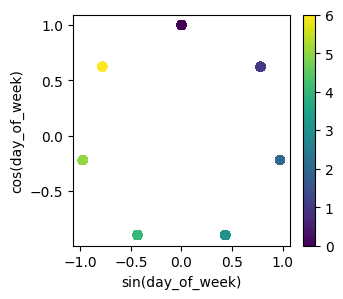

In [8]:
# Plot value of sin and cos for each day_of_week
# ==============================================================================
fig, ax = plt.subplots(figsize=(3.5, 3))
sp = ax.scatter(
         cyclical_features["day_of_week_sin"],
         cyclical_features["day_of_week_cos"],
         c    = calendar_features['day_of_week'],
         cmap = 'viridis'
     )
ax.set(
    xlabel="sin(day_of_week)",
    ylabel="cos(day_of_week)",
)
_ = fig.colorbar(sp)
plt.show();

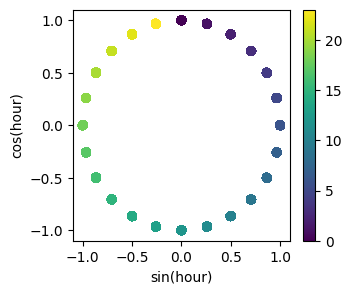

In [9]:
# Plot value of sin and cos for each hour
# ==============================================================================
fig, ax = plt.subplots(figsize=(3.5, 3))
sp = ax.scatter(
         cyclical_features["hour_sin"],
         cyclical_features["hour_cos"],
         c    = calendar_features['hour'],
         cmap = 'viridis'
     )
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)
plt.show();

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

See <a href="../faq/cyclical-features-time-series.html" target="_blank">Cyclical features in time series forecasting</a> for a more detailed description of strategies for encoding cyclic features.

</div>